In [1]:
# Welcome to Strangeworks Notebooks!
## import the necessary tools for our work
from IPython.display import clear_output
from qiskit import *
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plotter
from qiskit.tools.monitor import job_monitor
# Visualisation settings
import seaborn as sns, operator
sns.set_style("dark")

pi = np.pi

In [2]:
## Code for inverse Quantum Fourier Transform
## adapted from Qiskit Textbook at
## qiskit.org/textbook

def qft_dagger(circ_, n_qubits):
    """n-qubit QFTdagger the first n qubits in circ"""
    for qubit in range(int(n_qubits/2)):
        circ_.swap(qubit, n_qubits-qubit-1)
    for j in range(0,n_qubits):
        for m in range(j):
            circ_.cp(-np.pi/float(2**(j-m)), m, j)
        circ_.h(j)

In [3]:
## Code for initial state of Quantum Phase Estimation
## adapted from Qiskit Textbook at qiskit.org/textbook
## Note that the starting state is created by applying 
## H on the first n_qubits, and setting the last qubit to |psi> = |1>

def qpe_pre(circ_, n_qubits):
    circ_.h(range(n_qubits))
    circ_.x(n_qubits)

    for x in reversed(range(n_qubits)):
        for _ in range(2**(n_qubits-1-x)):
            circ_.cp(1, n_qubits-1-x, n_qubits)

In [4]:
## Run a Qiskit job on either hardware or simulators

def run_job(circ, backend, shots=1000, optimization_level=0):
    t_circ = transpile(circ, backend, optimization_level=optimization_level)
    qobj = assemble(t_circ, shots=shots)
    job = backend.run(qobj)
    job_monitor(job)
    return job.result().get_counts()

In [7]:
## Load your IBMQ account if 
## you'd like to use the cloud simulator or real quantum devices
IBMQ.save_account('04b297f668ded0e17daecdd7da786c3417303971439495cca50a0462259192653317c5bd9ddba6c58e585ec8618521f1dda368b7e7feb2b7e8e27b5a4c691d14')
my_provider = IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmq_santiago')

configrc.store_credentials:WARNING:2021-08-04 16:06:34,385: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2021-08-04 16:06:34,629: Credentials are already in use. The existing account in the session will be replaced.


In [9]:
simulator = Aer.get_backend('aer_simulator')

In [10]:
## Function to estimate pi
## Summary: using the notation in the Qiskit textbook (qiskit.org/textbook),
## do quantum phase estimation with the 'phase' operator U = p(theta) and |psi> = |1>
## such that p(theta)|1> = exp(2 x pi x i x theta)|1>
## By setting theta = 1 radian, we can solve for pi
## using 2^n x 1 radian = most frequently measured count = 2 x pi

def get_pi_estimate(n_qubits):

    # create the circuit
    circ = QuantumCircuit(n_qubits + 1, n_qubits)
    # create the input state
    qpe_pre(circ, n_qubits)
    # apply a barrier
    circ.barrier()
    # apply the inverse fourier transform
    qft_dagger(circ, n_qubits)
    # apply  a barrier
    circ.barrier()
    # measure all but the last qubits
    circ.measure(range(n_qubits), range(n_qubits))

    # run the job and get the results
    counts = run_job(circ, backend=simulator, shots=10000, optimization_level=0)
    # print(counts) 

    # get the count that occurred most frequently
    max_counts_result = max(counts, key=counts.get)
    max_counts_result = int(max_counts_result, 2)
    
    # solve for pi from the measured counts
    theta = max_counts_result/2**n_qubits
    return (1./(2*theta))

In [11]:
# estimate pi using different numbers of qubits
nqs = list(range(2,12+1))
pi_estimates = []
for nq in nqs:
    thisnq_pi_estimate = get_pi_estimate(nq)
    pi_estimates.append(thisnq_pi_estimate)
    print(f"{nq} qubits, pi ≈ {thisnq_pi_estimate}")

Job Status: job has successfully run
2 qubits, pi ≈ 2.0
Job Status: job has successfully run
3 qubits, pi ≈ 4.0
Job Status: job has successfully run
4 qubits, pi ≈ 2.6666666666666665
Job Status: job has successfully run
5 qubits, pi ≈ 3.2
Job Status: job has successfully run
6 qubits, pi ≈ 3.2
Job Status: job has successfully run
7 qubits, pi ≈ 3.2
Job Status: job has successfully run
8 qubits, pi ≈ 3.1219512195121952
Job Status: job has successfully run
9 qubits, pi ≈ 3.1604938271604937
Job Status: job has successfully run
10 qubits, pi ≈ 3.1411042944785277
Job Status: job has successfully run
11 qubits, pi ≈ 3.1411042944785277
Job Status: job has successfully run
12 qubits, pi ≈ 3.1411042944785277


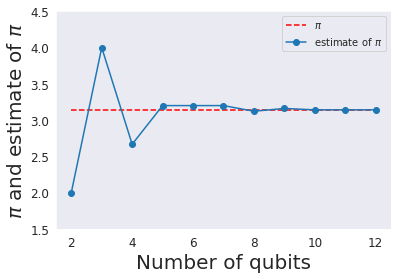

In [12]:
plotter.plot(nqs, [pi]*len(nqs), '--r')
plotter.plot(nqs, pi_estimates, '.-', markersize=12)
plotter.xlim([1.5, 12.5])
plotter.ylim([1.5, 4.5])
plotter.legend(['$\pi$', 'estimate of $\pi$'])
plotter.xlabel('Number of qubits', fontdict={'size':20})
plotter.ylabel('$\pi$ and estimate of $\pi$', fontdict={'size':20})
plotter.tick_params(axis='x', labelsize=12)
plotter.tick_params(axis='y', labelsize=12)
plotter.show()

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table